In [4]:
import matplotlib.pyplot as plt
from astropy.io import fits
import h5py
import os, glob

In [44]:
base_path = "/media/alexandre/Seagate/Data/HST_mag_limited_dataset/"
hf = h5py.File(base_path + "hudf_dataset.h5")

bands = ["b", "i", "v", "z"]
fits_files = {b: glob.glob(base_path + f"pstamps/{b}/*.fits") for b in bands}

# H5 dataset

In [45]:
hf.keys()

<KeysViewHDF5 ['hudf_ids', 'hudf_mags', 'hudf_resized', 'hudf_size', 'hudf_template', 'hudf_z']>

In [46]:
hf["hudf_resized"].shape

(8543, 4, 224, 224)

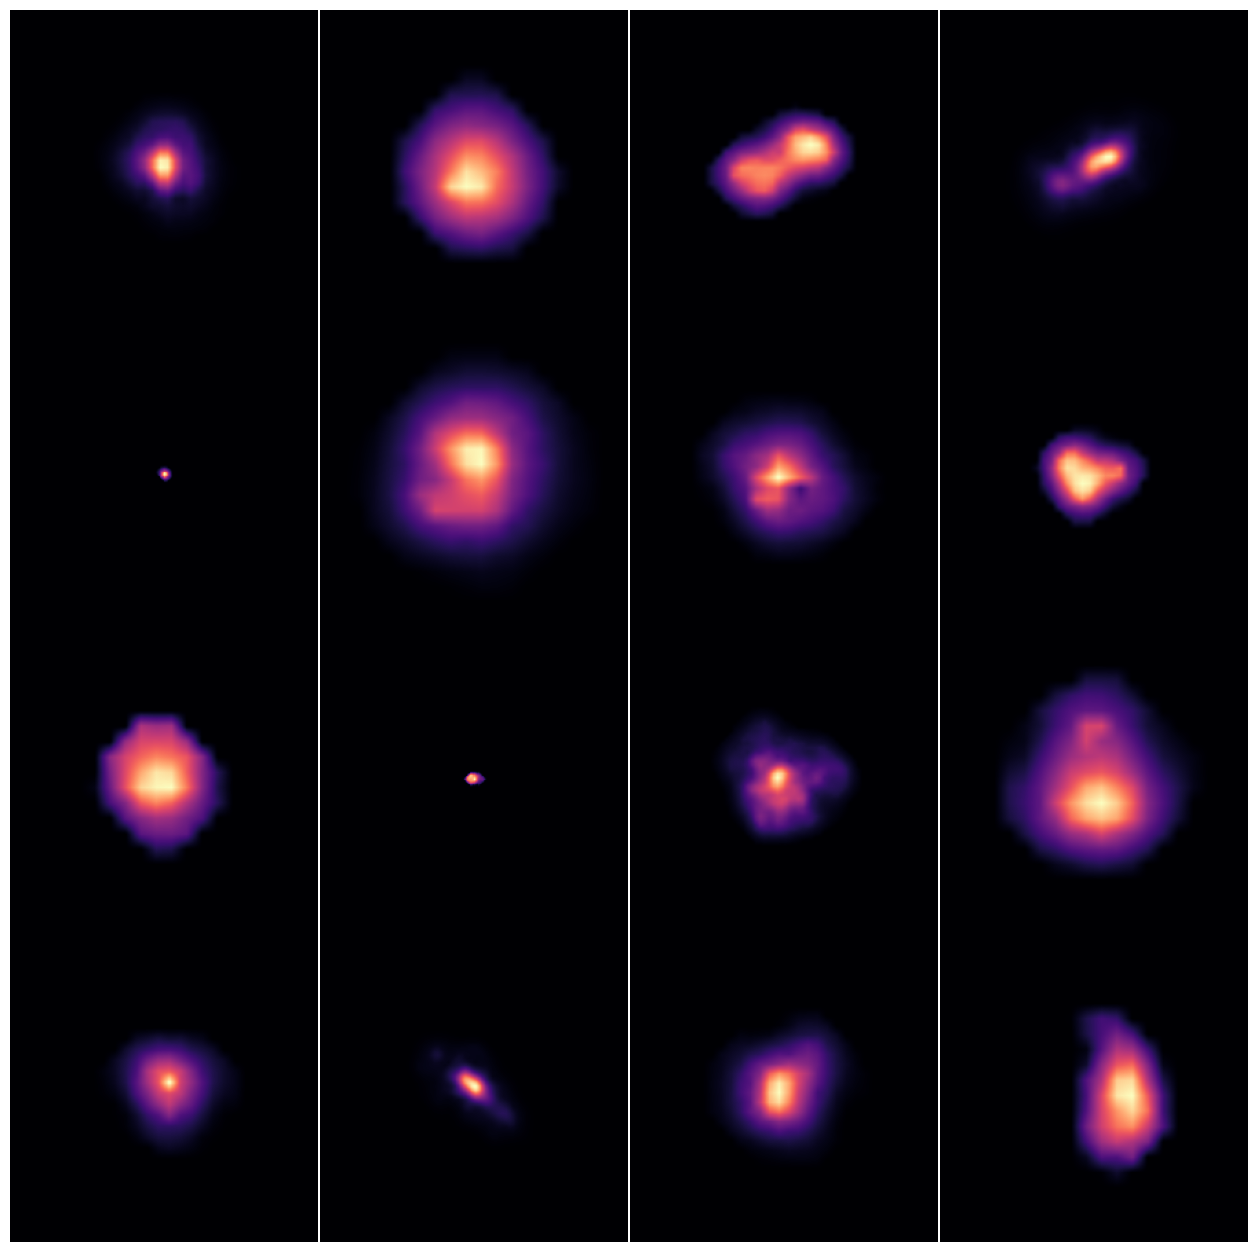

In [47]:
B = 16
band = 2
k = np.random.randint(len(hf["hudf_resized"]) - B)

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        ki = i * 4 + j
        axs[i, j].imshow(hf["hudf_resized"][k+ki, band], cmap="magma")
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)

# Fits file dataset

In [48]:
band = "i"
fits.open(fits_files[band][200])[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -64 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                   52 / length of data axis 1                          
NAXIS2  =                   52 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CREATOR = 'ShapeLens++'                                                         
BASEFILE= 'h_udf_wfc_i_drz_img.fits' / name of source file                      
ID      =                 2468 / object id                                      
XMIN    =                 6816 / min(X) in image pixels                         
YMIN    =                 38

In [49]:
sum([len(v) for v in fits_files.values()])

2245

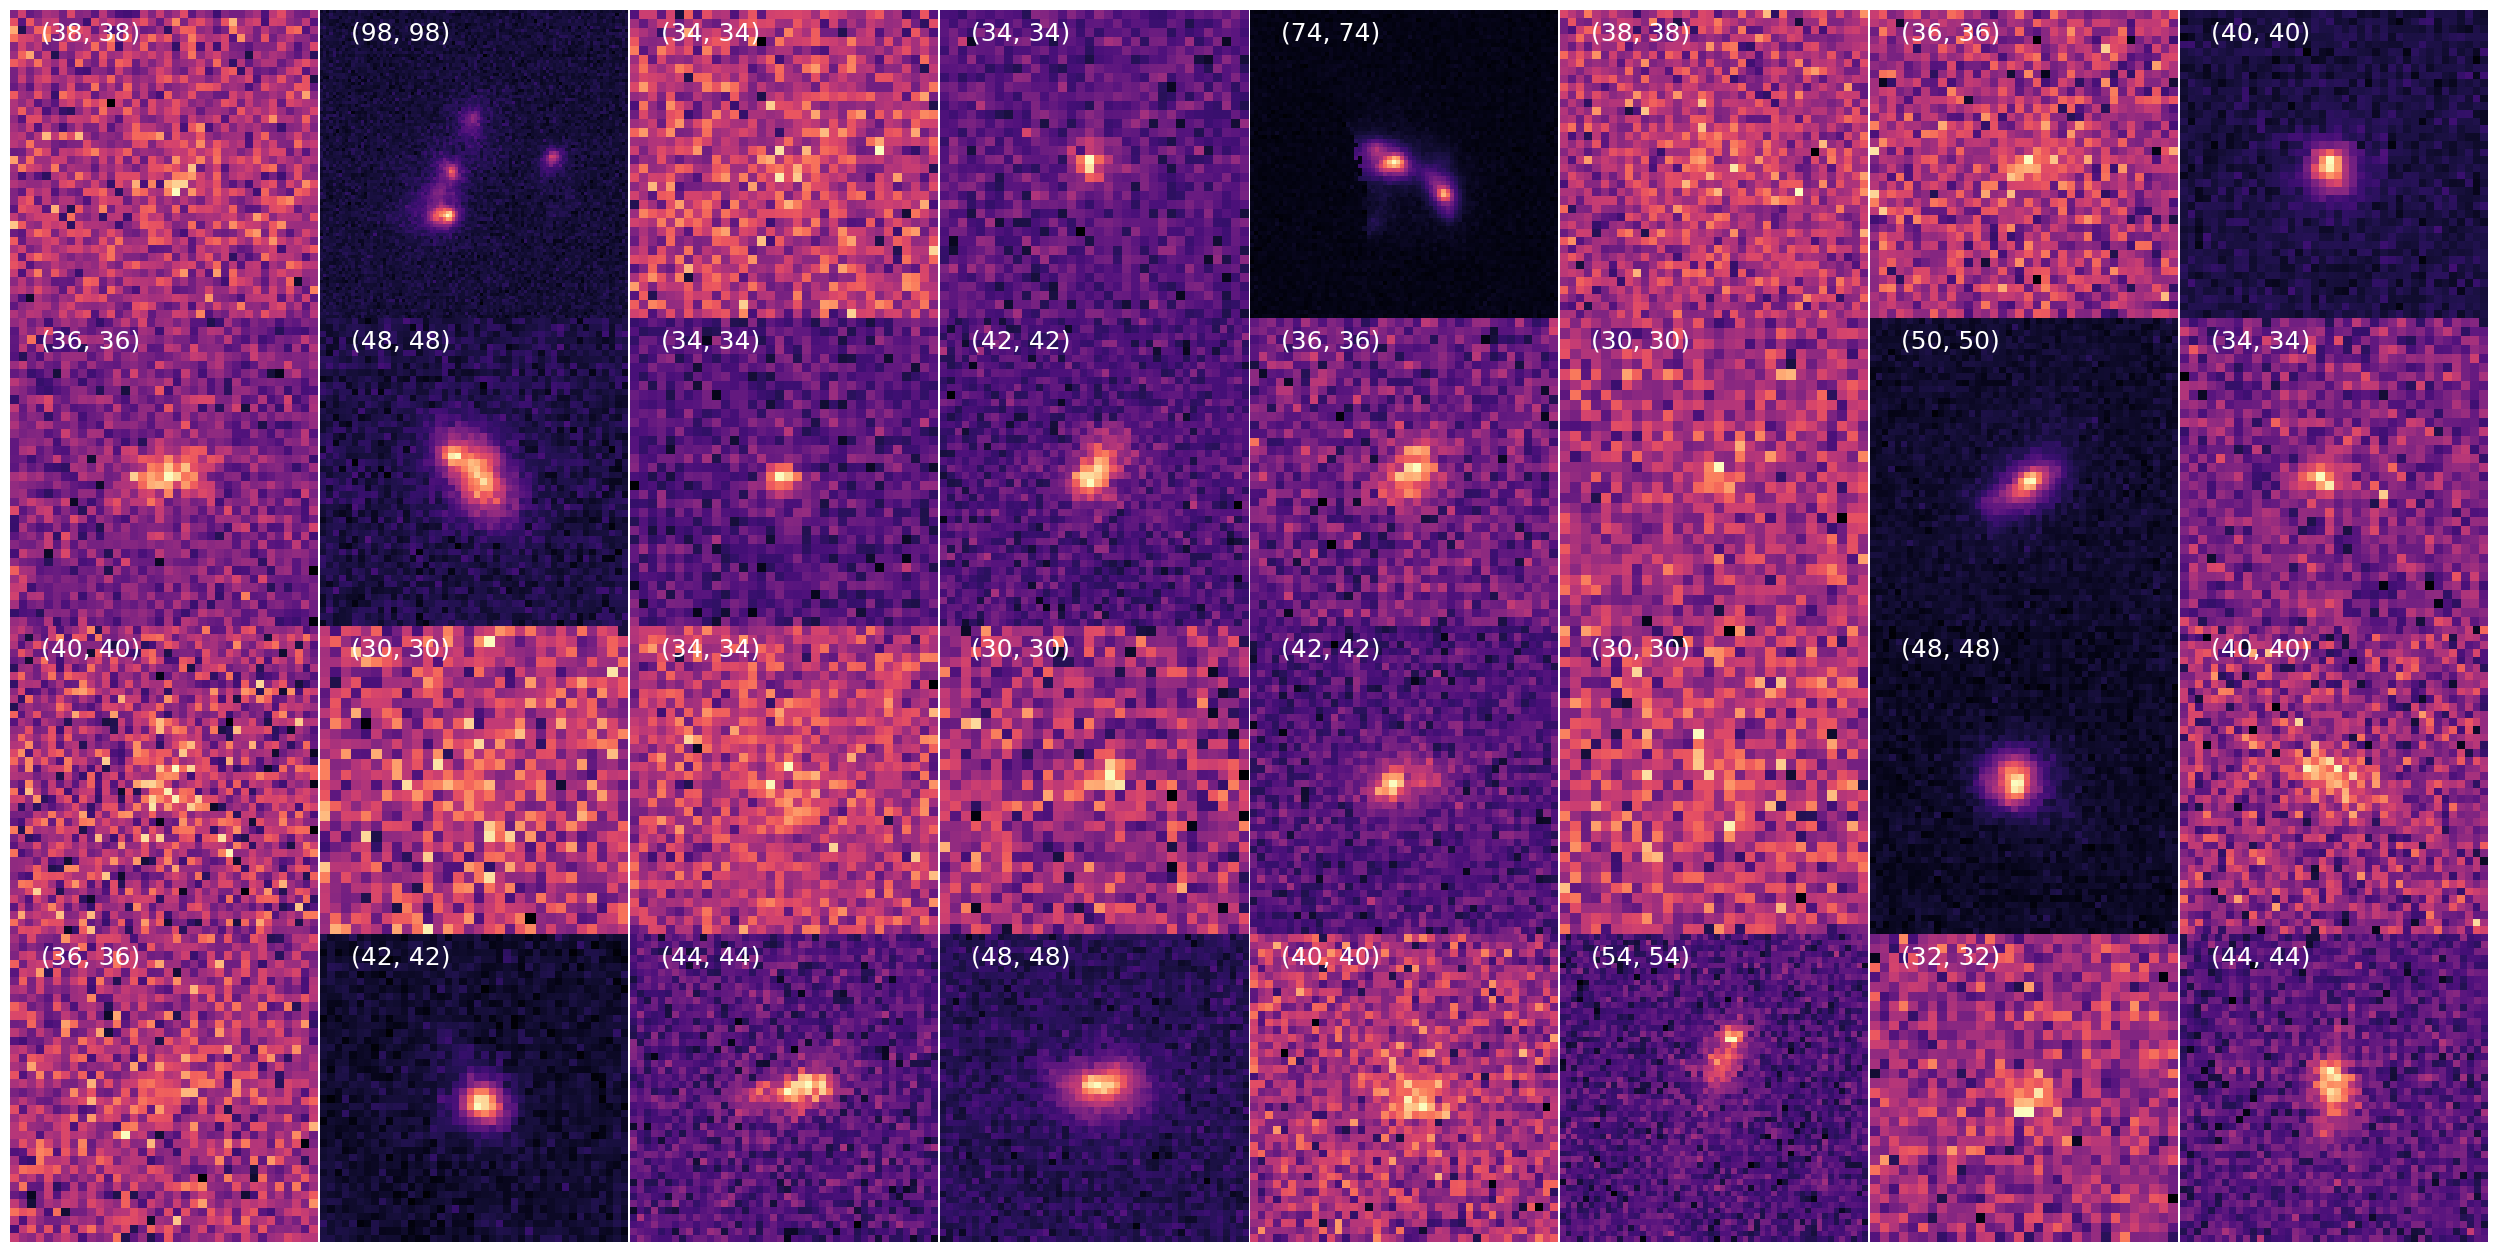

In [50]:
band = "i"
B = 32
k = np.random.randint(len(fits_files[band]) - B)


fig, axs = plt.subplots(4, 8, figsize=(32, 16))
for i in range(4):
    for j in range(8):
        ki = i * 8 + j
        img = fits.open(fits_files[band][k+ki])[0].data
        shape = img.shape
        axs[i, j].imshow(img, cmap="magma")
        axs[i, j].annotate(f"{shape}", xy=(0.1, 0.9), xycoords="axes fraction", color="w", fontsize=18)
        axs[i, j].axis("off")
plt.subplots_adjust(hspace=0, wspace=0)